# LightAutoML: ICE and PDP Interpretation Tutorial

Partial dependence plot (PDP) and Individual Conditional Expectation (ICE) are two model-agnostic interpretation methods (see details [here](https://compstat-lmu.github.io/iml_methods_limitations/pdp.html)).

## Download library and make some imports

In [1]:
# !pip install lightautoml

In [2]:
# Standard python libraries
import os
import time
import requests

# Installed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch


# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

In [3]:
plt.rcParams.update({'font.size': 20})
sns.set(rc={'figure.figsize':(15, 11)})
sns.set(style="whitegrid", font_scale=1.5)

N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 120 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name

## Prepare data

Load a dataset from the repository if doesn't clone repository by git.

In [4]:
DATASET_DIR = './data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

In [5]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)
        
data = pd.read_csv(DATASET_FULLNAME)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

CPU times: user 175 ms, sys: 38.9 ms, total: 214 ms
Wall time: 1.61 s


In [6]:
train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)

## Create AutoML from preset

Also works with ``lightautoml.automl.presets.tabular_presets.TabularUtilizedAutoML``.

In [7]:
%%time 

task = Task('binary', )
roles = {'target': TARGET_NAME,}

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1, log_file = 'train.log')

[22:50:15] Stdout logging level is INFO.
[22:50:15] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[22:50:15] Task: binary

[22:50:15] Start automl preset with listed constraints:
[22:50:15] - time: 120.00 seconds
[22:50:15] - CPU: 8 cores
[22:50:15] - memory: 16 GB

[22:50:15] Train data shape: (8000, 123)

[22:50:18] Layer 1 train process start. Time left 117.82 secs
[22:50:18] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:50:22] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7334750096679643
[22:50:22] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:50:22] Time left 113.67 secs

[22:50:24] Selector_LightGBM fitting and predicting completed
[22:50:24] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:50:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7365227303989069
[22:50:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:50:34] Start hyperparameters optimization for Lvl_

## Calculate interpretation data

ICE shows the functional relationship between the predicted response and the feature separately for each instance. PDP averages the individual lines of an ICE plot.

### Numeric features

For numeric features you can specify ``n_bins`` - number of bins into which the range of feature values is divided.

#### Calculate data for PDP plot manually:

In [8]:
%%time

grid, ys, counts = automl.get_individual_pdp(test_data, feature_name='DAYS_BIRTH', n_bins=30)

100%|██████████| 30/30 [00:13<00:00,  2.15it/s]

CPU times: user 41.8 s, sys: 218 ms, total: 42 s
Wall time: 14 s


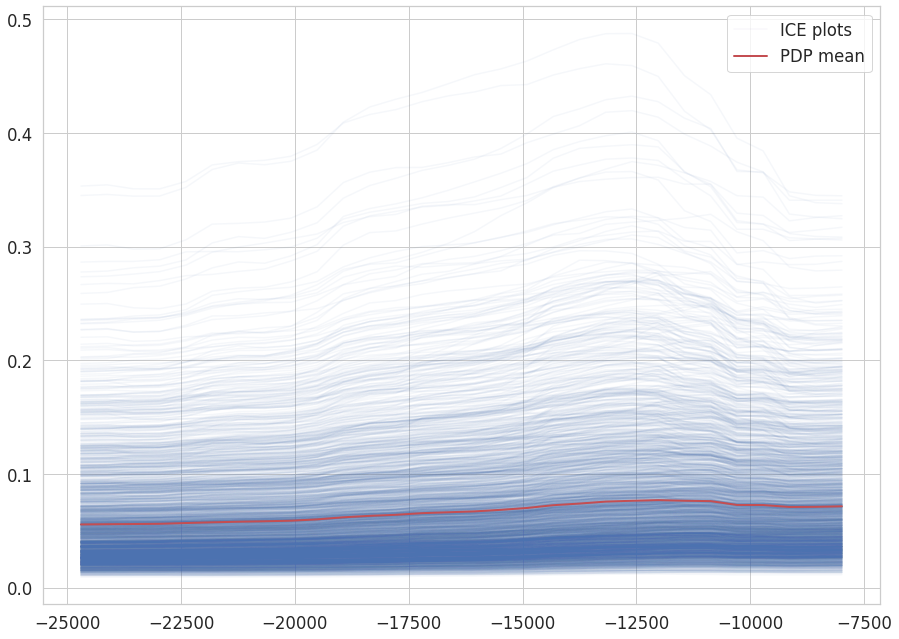

CPU times: user 2.23 s, sys: 19.3 ms, total: 2.24 s
Wall time: 2.24 s


In [9]:
%%time

X = np.array([item.ravel() for item in ys]).T

plt.figure(figsize=(15, 11))
plt.plot(grid, X[0], alpha=0.05, color='m', label='ICE plots')
for i in range(1, X.shape[0]):
    plt.plot(grid, X[i], alpha=0.05, color='b')
plt.plot(grid, X.mean(axis=0), linewidth=2, color='r', label='PDP mean')
plt.legend()
plt.show()

#### Built-in function:

100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


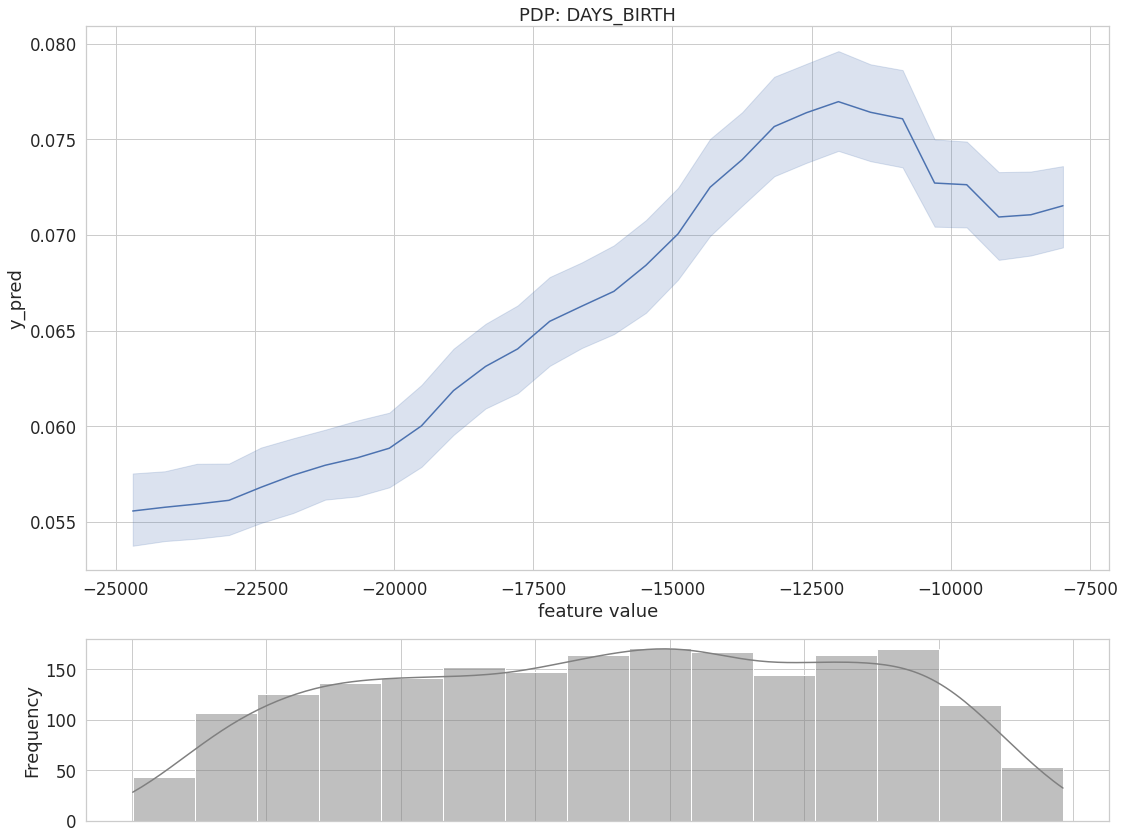

In [10]:
automl.plot_pdp(test_data, feature_name='DAYS_BIRTH')

100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


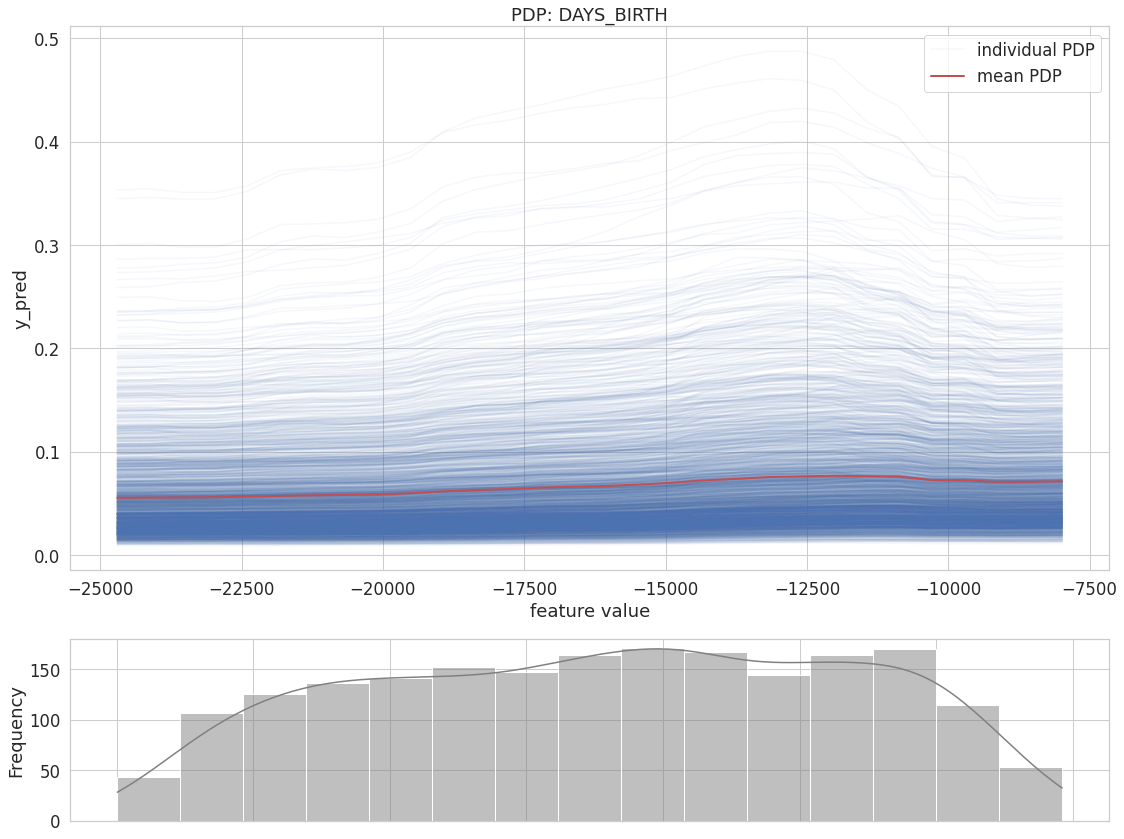

In [11]:
automl.plot_pdp(test_data, feature_name='DAYS_BIRTH', individual=True)

### Categorical features

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


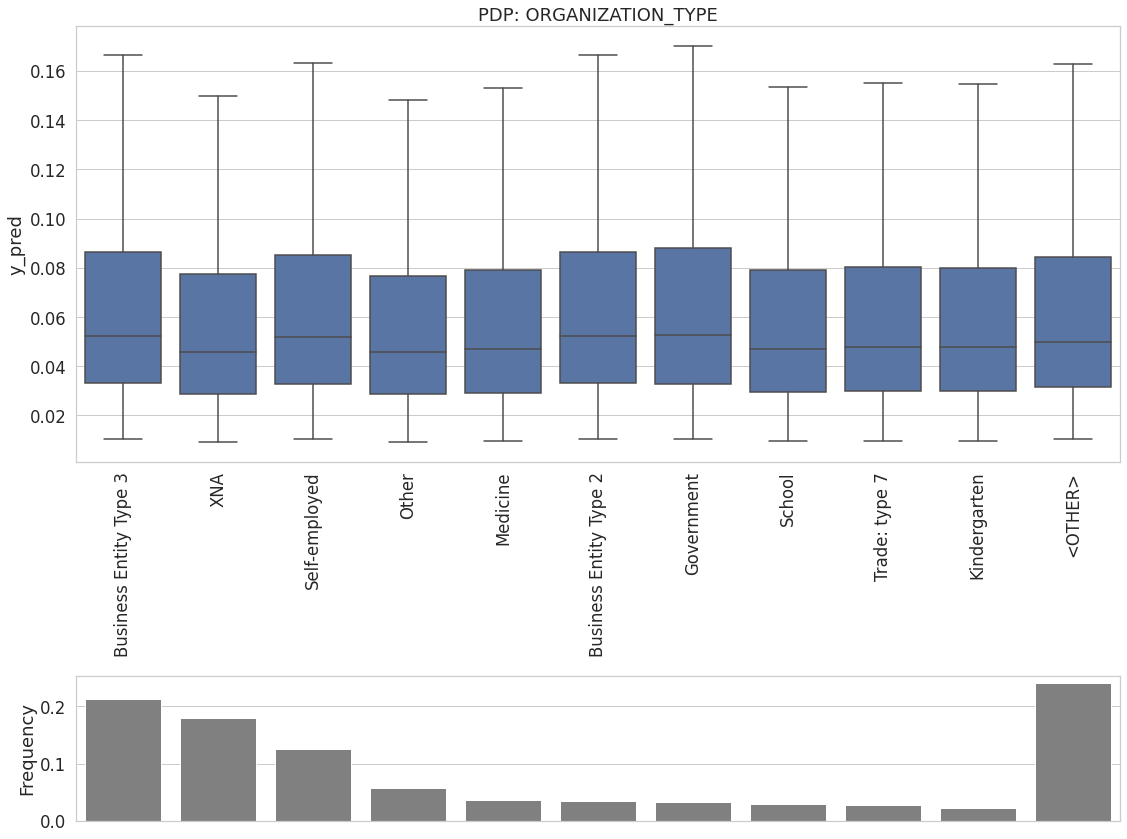

CPU times: user 15.1 s, sys: 160 ms, total: 15.3 s
Wall time: 5.23 s


In [12]:
%%time

automl.plot_pdp(test_data, feature_name='ORGANIZATION_TYPE')

### Datetime features

For datetime features you can specify groupby level, allowed values: ``year``, ``month``, ``dayofweek``.

100%|██████████| 45/45 [00:20<00:00,  2.15it/s]


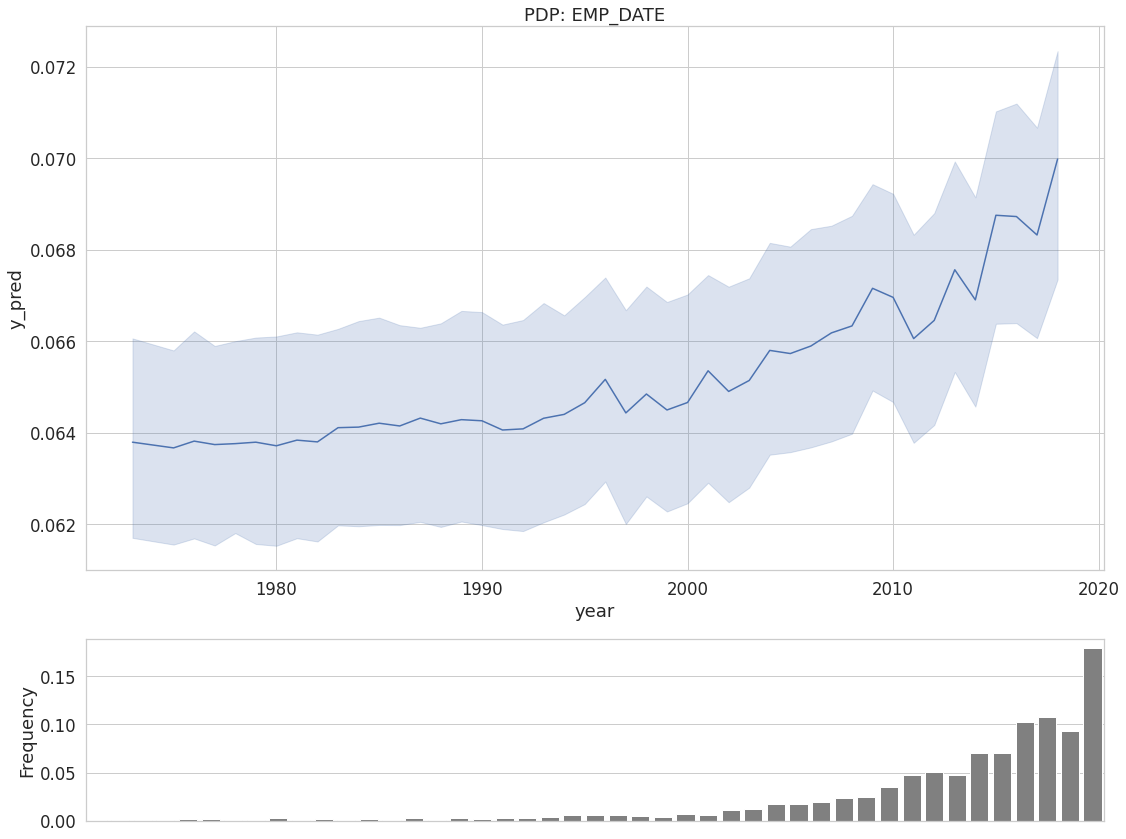

CPU times: user 1min 3s, sys: 468 ms, total: 1min 4s
Wall time: 22.9 s


In [13]:
%%time

automl.plot_pdp(test_data, feature_name='EMP_DATE', datetime_level='year')